In [25]:
import tensorflow as tf
import tensorflow_datasets as tfds
import logging
from uuid import uuid4
from datetime import datetime
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from CompressionLibrary.agent_evaluators import make_env_imagenet, evaluate_agents
from CompressionLibrary.reinforcement_models import DQNAgent


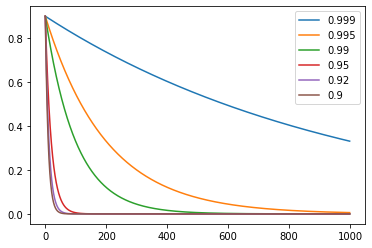

In [26]:
x = list(range(1000))
r = [0.999, 0.995, 0.99, 0.95, 0.92, 0.9]
for v in r:
    f = lambda a: 0.9*v**a
    y = list(map(f,x))
    plt.plot(x,y)

legends = list(map(str, r))
plt.legend(legends)


In [27]:
dataset_name = 'kmnist'
agent_name = '-'.join(['mnist', 'kmnist'])
run_id = datetime.now().strftime('%Y-%m-%d-%H-%M%S-') + str(uuid4())

try:
  # Use below for TPU
  resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='local')
  tf.config.experimental_connect_to_cluster(resolver)
  # This is the TPU initialization code that has to be at the beginning.
  tf.tpu.experimental.initialize_tpu_system(resolver)
  print("All devices: ", tf.config.list_logical_devices('TPU'))
  strategy = tf.distribute.TPUStrategy(resolver)
  data_path = '/mnt/disks/mcdata/data'

except:
  print('ERROR: Not connected to a TPU runtime; Using GPU strategy instead!')
  strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
  data_path = './data'
  
if strategy:
    print('Number of devices: {}'.format(strategy.num_replicas_in_sync))


logging.basicConfig(level=logging.DEBUG, handlers=[
    logging.FileHandler(f'/home/A00806415/DCC/ModelCompression/data/ModelCompression_test_{dataset_name}.log', 'w+')],
    format='%(asctime)s -%(levelname)s - %(funcName)s -  %(message)s')
logging.root.setLevel(logging.DEBUG)

log = logging.getLogger('tensorflow')
log.setLevel(logging.ERROR)


current_state = 'layer_input'
next_state = 'layer_output'

epsilon_start_value = 0.9
verbose = 0
eval_n_samples = 10
n_samples_mode = -1
tuning_batch_size = 128
tuning_epochs = 30

layer_name_list = ['conv2d_1',  'dense', 'dense_1']





ERROR: Not connected to a TPU runtime; Using GPU strategy instead!
Number of devices: 1


# Model creation and data loading.


In [28]:
def create_model():
    checkpoint_path = f"./data/models/lenet_{dataset_name}/cp.ckpt"
    optimizer = tf.keras.optimizers.Adam(1e-5)
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
    train_metric = tf.keras.metrics.SparseCategoricalAccuracy()
    input = tf.keras.layers.Input((28,28,1))
    x = tf.keras.layers.Conv2D(6, (5,5), padding='SAME', activation='sigmoid', name='conv2d')(input)
    x = tf.keras.layers.AveragePooling2D((2,2), strides=2, name='avg_pool_1')(x)
    x = tf.keras.layers.Conv2D(16, (5,5), padding='VALID', activation='sigmoid', name='conv2d_1')(x)
    x = tf.keras.layers.AveragePooling2D((2,2), strides=2, name='avg_pool_2')(x)
    x = tf.keras.layers.Flatten(name='flatten')(x)
    x = tf.keras.layers.Dense(120, activation='sigmoid', name='dense')(x)
    x = tf.keras.layers.Dense(84, activation='sigmoid', name='dense_1')(x)
    x = tf.keras.layers.Dense(10, activation='softmax', name='predictions')(x)

    model = tf.keras.Model(input, x, name='LeNet')
    model.compile(optimizer=optimizer, loss=loss_object,
                    metrics=[train_metric])

    try:
        model.load_weights(checkpoint_path).expect_partial()
    except:
        cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True,
                                                 save_weights_only=True,
                                                 verbose=1)
        model.fit(train_ds,
          epochs=3000,
          validation_data=valid_ds,
          callbacks=[cp_callback])

    return model       

def dataset_preprocessing(img, label):
    img = tf.cast(img, tf.float32)
    img = img/255.0
    return img, label

def load_dataset(batch_size=128):
    splits, info = tfds.load(dataset_name, as_supervised=True, with_info=True, shuffle_files=True, 
                                split=['train[:80%]', 'train[80%:]','test'])

    (train_examples, validation_examples, test_examples) = splits
    num_examples = info.splits['train'].num_examples

    num_classes = info.features['label'].num_classes
    input_shape = info.features['image'].shape

    input_shape = (28,28,1)

    train_ds = train_examples.map(dataset_preprocessing, num_parallel_calls=tf.data.AUTOTUNE).shuffle(buffer_size=1000, reshuffle_each_iteration=True).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    valid_ds = validation_examples.map(dataset_preprocessing, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    test_ds = test_examples.map(dataset_preprocessing, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return train_ds, valid_ds, test_ds, input_shape, num_classes

train_ds, valid_ds, test_ds, input_shape, _ = load_dataset(tuning_batch_size)

# Creation of agent

In [29]:

input_shape = (28,28,1)
env = make_env_imagenet(
            create_model=create_model, 
            train_ds=train_ds, 
            valid_ds=valid_ds, 
            test_ds=test_ds, 
            input_shape=input_shape, 
            layer_name_list=layer_name_list, 
            num_feature_maps=n_samples_mode, 
            tuning_batch_size=tuning_batch_size, 
            tuning_epochs=tuning_epochs, 
            verbose=verbose, 
            tuning_mode='layer', 
            current_state_source=current_state, 
            next_state_source=next_state, 
            strategy=strategy, 
            model_path=data_path)
env.model.summary()

conv_shape, dense_shape = env.observation_space()
conv_n_actions, fc_n_actions = env.action_space()

print(conv_shape, dense_shape)

def load_weigths_into_target_network(agent, target_network):
    """ assign target_network.weights variables to their respective agent.weights values. """
    for i in range(len(agent.model.layers)):
        target_network.model.layers[i].set_weights(
            agent.model.layers[i].get_weights())


with strategy.scope():
    
    fc_agent = DQNAgent("dqn_agent_fc", dense_shape,
                        fc_n_actions, epsilon=epsilon_start_value, layer_type='fc')
    fc_target_network = DQNAgent(
        "target_network_fc", dense_shape, fc_n_actions, layer_type='fc')

    fc_agent.model.summary()

    conv_agent = DQNAgent("dqn_agent_conv", conv_shape,
                        conv_n_actions, epsilon=epsilon_start_value, layer_type='cnn')
    conv_target_network = DQNAgent(
        "target_network_conv", conv_shape, conv_n_actions, layer_type='cnn')


    

    try:
        conv_target_network.model.load_weights(
            data_path+'/checkpoints/{}_my_checkpoint_conv_agent'.format(agent_name))
        fc_target_network.model.load_weights(
            data_path+'/checkpoints/{}_my_checkpoint_fc_agent'.format(agent_name))
    except:
        print('Failed to find pretrained models for the RL agents.')
        pass


Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 6)         156       
_________________________________________________________________
avg_pool_1 (AveragePooling2D (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
avg_pool_2 (AveragePooling2D (None, 5, 5, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 400)               0         
_________________________________________________________________
dense (Dense)                (None, 120)               481

# Evaluation of results

In [30]:
rw, acc, weights = evaluate_agents(env, conv_agent, fc_agent,run_id=run_id,test_number=0, dataset_name=dataset_name,save_name=data_path+'/test_generalist_training_ds.csv', n_games=eval_n_samples)    